# MakeMore Tutorial

This is extension from the first notebook (just to have a clean start).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**HParams**

Hyper parameters used, so that we define them all in one place

In [10]:
heads = 5
emb_size = 64
hidden_layer = 512

**Data Loading**

Loads the names data and splits it into heads

In [4]:
import random
from typing import List, Callable
from torch import nn
from torch.nn import functional as F

# load the name data
with open("data/names.txt") as f:
    names = f.read().splitlines()

# print stats
print("Number of names: ", len(names))

# split names into bigrams
bigrams = {}
for name in names:
    ls = ["<T>"] + list(name.lower()) + ["<T>"]
    tpl = list(zip(ls, ls[1:]))
    for bigram in tpl:
        bigrams[bigram] = bigrams.get(bigram, 0) + 1
items = sorted(list(set([b for a, b in bigrams.keys()])))
pos_map = {v: k for k, v in enumerate(items)}
num_items = len(items)
t_bigrams = torch.zeros((num_items, num_items))


# split names into 3 datasets (based on percentages)
train_perc, dev_perc, eval_perc = 0.8, 0.1, 0.1

# shuffle and split names
random.shuffle(names)
train_names = names[: int(len(names) * train_perc)]
dev_names = names[
    int(len(names) * train_perc) : int(len(names) * (train_perc + dev_perc))
]
eval_names = names[int(len(names) * (train_perc + dev_perc)) :]

# print stats
print(f"Train: {len(train_names)}")
print(f"Dev: {len(dev_names)}")
print(f"Eval: {len(eval_names)}")


def gen_dataset(items: List[str], encode: Callable[[str], List[int]], heads: int):
    train = []
    label = []
    for name in items:
        ls = [0] * heads + encode(name) + [0]
        tpl = list(zip(ls, *[ls[i + 1 :] for i in range(heads)]))
        for bigram in tpl:
            train.append(bigram[:-1])
            label.append(bigram[-1])

    # convert to tensors and expand as one-hots
    train = torch.tensor(train)
    label = F.one_hot(torch.tensor(label), num_items)
    return train, label

def char_encoding(name: str) -> List[int]:
    return [pos_map[i] for i in list(name.lower())]

print(f"Vocab Size: {num_items}")

Number of names:  32033
Train: 25626
Dev: 3203
Eval: 3204
Vocab Size: 27


In [3]:
num_mlp_items = len(pos_map)

train_X, train_y = gen_dataset(train_names, char_encoding, heads=heads)
dev_X, dev_y = gen_dataset(dev_names, char_encoding, heads=heads)
eval_X, eval_y = gen_dataset(eval_names, char_encoding, heads=heads)
print(train_X.shape)
print(dev_X.shape)
print(eval_X.shape)

torch.Size([182516, 5])
torch.Size([22771, 5])
torch.Size([22859, 5])


**Helpers**

Some general helper functions

In [22]:
from torchviz import make_dot
from typing import Tuple, Any

# plots the given model
def plot_mlp(model, X=train_X):
    return make_dot(model.forward(X), params=dict(model.named_parameters()))

def compute_nll(model, X, y):
    # compute the loss
    probs = model.predict_proba(X)
    lhood = (probs * y).sum(dim=1)
    # take mean to make usre large data is still handlable
    return -torch.log(lhood).mean()

def count_parameters(model):
    # sum number of elements in all model parameters that take a gradient
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def grid_space_lr(exp_start, exp_end, num) -> Tuple[torch.Tensor, torch.Tensor]:
    # NOTE: this can be used by single training steps (random data) then check when the loss explodes
    # generate a grid of learning rates
    space = torch.linspace(exp_start, exp_end, num)
    return 10**space, space

def grid_search_lr(model, exp_start: int, exp_end: int, steps: int, train_X: torch.Tensor, train_y: torch.Tensor, loss_fct: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], batch_size: int = 1000):
    # generate grid space
    lrs, lri = grid_space_lr(exp_start, exp_end, steps)

    # train model for each learning rate
    losses = []
    for i in range(len(lrs)):
        # sample from trainX and trainY
        idx = torch.randint(0, train_X.shape[0], (batch_size,))
        batch_X = train_X[idx]
        batch_y = train_y[idx]

        # compute loss
        probs = model(batch_X)
        loss = loss_fct(probs, batch_y)
        loss.backward()

        # optimize
        for p in model.parameters():
            p.data -= lrs[i] * p.grad.data
            p.grad.data.zero_()

        # compute loss
        losses.append(loss.sum().item())
    
    # plot data
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(lri, losses)
    ax.set_xlabel("Learning Rate Exp")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Learning Rate Exp")
    plt.show()

    return losses, lri


**MLP**

Definition of the MLP Model and define the learning rate curve.

Model has 179931 parameters


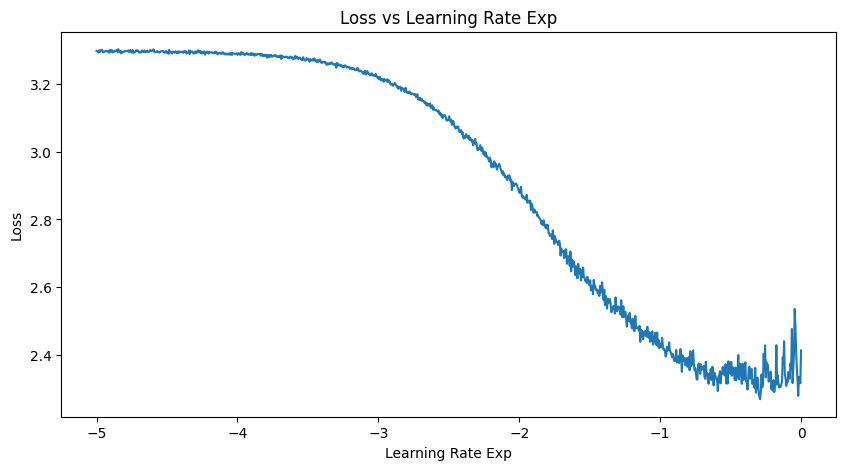

In [28]:
from sklearn.decomposition import PCA
from typing import Dict


class MLPNet(nn.Module):
    def __init__(
        self,
        char_map: Dict[int, str],
        num_items: int,
        emb_size: int = 64,
        hidden_size: int = 512,
        heads: int = 3,
        act: Callable[[torch.Tensor], torch.Tensor] = torch.tanh,
    ):
        super(MLPNet, self).__init__()
        self.heads = heads
        self.emb_size = emb_size
        self.act = act
        self.char_map = char_map

        # generate data
        self.emb_mat = nn.Parameter(
            torch.randn(num_items, emb_size, requires_grad=True)
        )
        # FEAT: add residual connections
        self.linear_stack = nn.Sequential(
            nn.Linear(heads * emb_size, hidden_size),
            self.act,
            nn.Linear(hidden_size, num_items),
        )

    def forward(self, x):
        # update the X (if out of shape)
        x = x.unqueeze(0) if len(x.shape) == 1 else x
        x = x.long()

        # retrieve embeddings and concat
        embs = self.emb_mat[x]
        embs = embs.view(-1, self.heads * self.emb_size)
        embs = self.act(embs)

        logits = self.linear_stack(embs)
        return logits

    def predict_proba(self, x):
        return torch.softmax(self.forward(x), dim=1)

    def predict(self, x):
        logits = self.predict_proba(x)
        return torch.argmax(logits, dim=1)

    def sample_word(self, size: int = 100) -> str:
        word = ""
        chars = [0] * self.heads
        for i in range(size):
            probs = self.predict_proba(torch.tensor([chars]))
            # sample from the distribution
            sample = torch.multinomial(probs[0], 1, replacement=True).item()
            if sample == 0:
                break

            chars = chars[1:] + [sample]
            word += self.char_map[sample]

        return word

    def plot_embeddings(self):
        emb_points = self.emb_mat.detach().numpy()

        # use PCA to reduce the dimensionality
        if emb_points.shape[1] > 2:
            pca = PCA(n_components=2)
            emb_points = pca.fit_transform(emb_points)

        # plot the embedding points on a 2D plane
        plt.figure(figsize=(10, 10))
        # and label the points
        plt.scatter(emb_points[:, 0], emb_points[:, 1], s=250)

        # plot the labels
        for i, label in enumerate(pos_map):
            plt.annotate(
                label,
                (emb_points[i, 0], emb_points[i, 1]),
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )
        plt.show()

# create model
def create_model():
    return MLPNet(items, num_items, emb_size=emb_size, hidden_size=hidden_layer, heads=heads, act=torch.nn.Tanh())

model = create_model()
print(f"Model has {count_parameters(model)} parameters")
# plot the learning rate data
ce_loss = lambda p, y: F.cross_entropy(p, torch.argmax(y, dim=1))
losses, lri = grid_search_lr(create_model(), -5, 0, 1000, train_X, train_y, ce_loss, batch_size=5000)

Epoch 0 - Train Loss: 2.242489814758301 - Test Loss: 2.2459757328033447
Epoch 1 - Train Loss: 2.2393250465393066 - Test Loss: 2.24385929107666
Epoch 2 - Train Loss: 2.2539098262786865 - Test Loss: 2.257380485534668
Epoch 3 - Train Loss: 2.2236883640289307 - Test Loss: 2.227910280227661
Epoch 4 - Train Loss: 2.2200045585632324 - Test Loss: 2.2249233722686768
Epoch 5 - Train Loss: 2.2194507122039795 - Test Loss: 2.22465443611145
Epoch 6 - Train Loss: 2.2204623222351074 - Test Loss: 2.2264575958251953
Epoch 7 - Train Loss: 2.2146060466766357 - Test Loss: 2.2203476428985596
Epoch 8 - Train Loss: 2.2059571743011475 - Test Loss: 2.2130019664764404
Epoch 9 - Train Loss: 2.201915979385376 - Test Loss: 2.2090911865234375
Epoch 10 - Train Loss: 2.198789596557617 - Test Loss: 2.2063894271850586
Epoch 11 - Train Loss: 2.199263572692871 - Test Loss: 2.207573890686035
Epoch 12 - Train Loss: 2.1973583698272705 - Test Loss: 2.2049577236175537
Epoch 13 - Train Loss: 2.1900947093963623 - Test Loss: 2.19

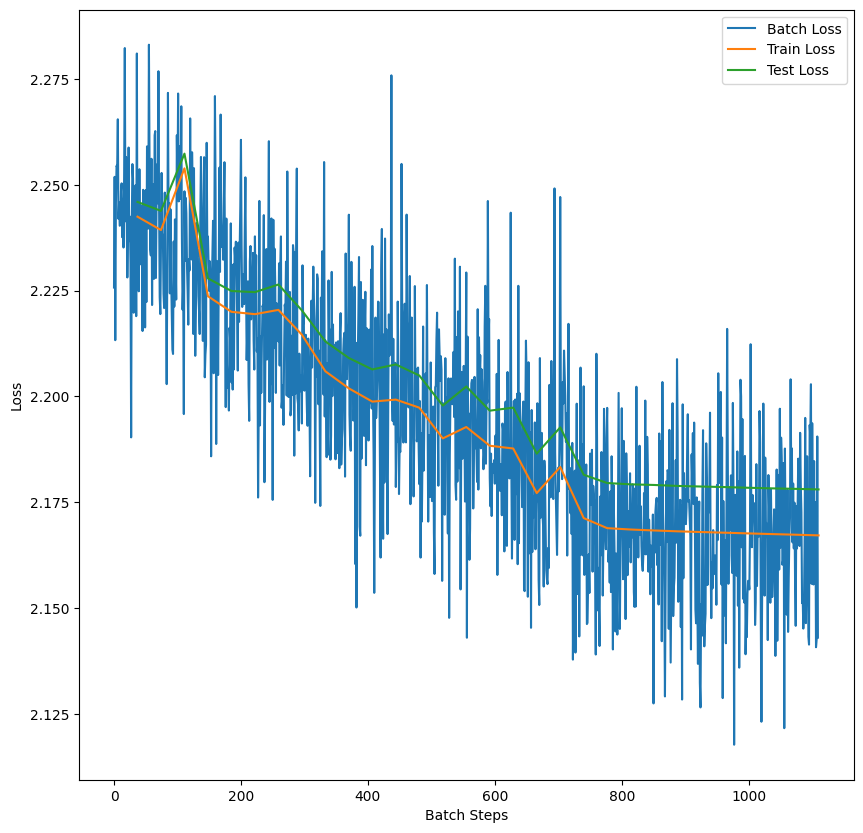

In [30]:
def clean_stats():
    return {
        "batch_loss": [],
        "train_loss": [],
        "test_loss": [],
        "epoch_steps": [],
    }

# define model and optimization cycle
def optimize(model, epochs, train_X, train_y, test_X, test_y, loss_fct, batch_size: int = 1000, lr: float = 1e-3, stats = None):
    # create some statistics
    stats = stats or clean_stats()

    # sample from trainX and trainY
    for ep in range(epochs):
        # shuffle the train data
        idx = torch.randperm(train_X.shape[0])
        train_X = train_X[idx]
        train_y = train_y[idx]

        # iterate over the batches
        for i in range(0, train_X.shape[0], batch_size):
            batch_X = train_X[i : i + batch_size]
            batch_y = train_y[i : i + batch_size]

            # compute loss
            probs = model(batch_X)
            loss = loss_fct(probs, batch_y)
            loss.backward()

            # optimize
            for p in model.parameters():
                p.data -= lr * p.grad.data
                p.grad.data.zero_()

            # update statistics
            stats["batch_loss"].append(loss.sum().item())
        
        # compute epoch loss
        with torch.no_grad():
            train_loss = loss_fct(model(train_X), train_y).sum().item()
            test_loss = loss_fct(model(test_X), test_y).sum().item()
            stats["train_loss"].append(train_loss)
            stats["test_loss"].append(test_loss)
            stats["epoch_steps"].append(len(stats["batch_loss"]))

        print(f"Epoch {ep} - Train Loss: {train_loss} - Test Loss: {test_loss}")

    return stats

def plot_stats(stats):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(len(stats["batch_loss"])), stats["batch_loss"], label="Batch Loss")
    ax.plot(stats["epoch_steps"], stats["train_loss"], label="Train Loss")
    ax.plot(stats["epoch_steps"], stats["test_loss"], label="Test Loss")
    ax.set_xlabel("Batch Steps")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.show()

stats = optimize(model, 20, train_X, train_y, dev_X, dev_y, ce_loss, batch_size=5000, lr=2e-1)
stats = optimize(model, 10, train_X, train_y, dev_X, dev_y, ce_loss, batch_size=5000, lr=1e-2, stats=stats)
plot_stats(stats)